In [1]:
import sys
sys.path

['D:\\bio\\jupyter_code\\MouseOlfactoryBulb',
 'D:\\anaconda\\envs\\scSLAT\\python38.zip',
 'D:\\anaconda\\envs\\scSLAT\\DLLs',
 'D:\\anaconda\\envs\\scSLAT\\lib',
 'D:\\anaconda\\envs\\scSLAT',
 '',
 'C:\\Users\\23147\\AppData\\Roaming\\Python\\Python38\\site-packages',
 'D:\\anaconda\\envs\\scSLAT\\lib\\site-packages',
 'D:\\anaconda\\envs\\scSLAT\\lib\\site-packages\\win32',
 'D:\\anaconda\\envs\\scSLAT\\lib\\site-packages\\win32\\lib',
 'D:\\anaconda\\envs\\scSLAT\\lib\\site-packages\\Pythonwin']

In [2]:
# uncomment this if you want to use interactive plot (only works in Jupyter not works in VScode)
# %matplotlib widget

import scanpy as sc
import numpy as np
import pandas as pd
import anndata as ad

import scSLAT
from scSLAT.model import Cal_Spatial_Net, load_anndatas, run_SLAT, spatial_match
from scSLAT.viz import match_3D_multi, hist, Sankey
from scSLAT.metrics import region_statistics

In [3]:
sc.set_figure_params(scanpy=True, dpi=100, dpi_save=150, frameon=True, vector_friendly=True, fontsize=14)

In [4]:
# datasets = ["10X","slide","stereo"]
datasets = ["slide","stereo"]
experiment_name = 'MouseOB'
input_dir = 'G:/dataset/06-Mouse olfactory bulb/input/35um/'
output_dir = 'G:/dataset/06-Mouse olfactory bulb/output/35um/SLAT/'

In [5]:
adata_list = []

for dataset in datasets:
    adata = sc.read_h5ad(input_dir + '/' + dataset + '.h5ad')
    df = adata.obs[['x','y']].astype('float32')
    adata.obsm['spatial'] = df.values
    # adata = adata[~pd.isna(adata.obs['x'])]
    adata_list.append(adata)

In [6]:
print(adata_list[0])
print(adata_list[1])

AnnData object with n_obs × n_vars = 18537 × 5531
    obs: 'orig.ident', 'nCount_slide', 'nFeature_slide', 'celltype', 'batch', 'x', 'y'
    var: 'features'
    obsm: 'spatial'
AnnData object with n_obs × n_vars = 8827 × 5531
    obs: 'orig.ident', 'nCount_stereo', 'nFeature_stereo', 'celltype', 'batch', 'x', 'y'
    var: 'features'
    obsm: 'spatial'


In [7]:
Cal_Spatial_Net(adata_list[0], k_cutoff=5, model='KNN')
Cal_Spatial_Net(adata_list[1], k_cutoff=5, model='KNN')

Calculating spatial neighbor graph ...
The graph contains 106617 edges, 18537 cells.
5.75157792523062 neighbors per cell on average.
Calculating spatial neighbor graph ...
The graph contains 44511 edges, 8827 cells.
5.042596578679053 neighbors per cell on average.


In [8]:
edges, features = load_anndatas([adata_list[0], adata_list[1]], feature='DPCA', check_order=False)

embd0, embd1, time = run_SLAT(features, edges)

best, index, distance = spatial_match(features, adatas=[adata_list[0],adata_list[1]], reorder=False)

Use DPCA feature to format graph


D:\anaconda\envs\scSLAT\lib\site-packages\anndata\_core\anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
D:\anaconda\envs\scSLAT\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
D:\anaconda\envs\scSLAT\lib\site-packages\scanpy\preprocessing\_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
D:\anaconda\envs\scSLAT\lib\site-packages\scanpy\preprocessing\_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))
D:\anaconda\envs\scSLAT\lib\site-packages\scanpy\preprocessing\_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy

Warning! Dual PCA is using GPU, which may lead to OUT OF GPU MEMORY in big dataset!
Choose GPU:0 as device
Running
---------- epochs: 1 ----------
---------- epochs: 2 ----------
---------- epochs: 3 ----------
---------- epochs: 4 ----------
---------- epochs: 5 ----------
---------- epochs: 6 ----------
Training model time: 8.43


In [9]:
print(type(embd0))
print(embd0.shape)
print(embd1.shape)

<class 'torch.Tensor'>
torch.Size([18537, 2048])
torch.Size([8827, 2048])


dataset1: 6 cell types; dataset2: 8 cell types; 
                    Total :9 celltypes; Overlap: 5 cell types 
                    Not overlap :[['EPL', 'OPL', 'Meninges', 'Low_Quality']]
Subsample 300 cell pairs from 8827


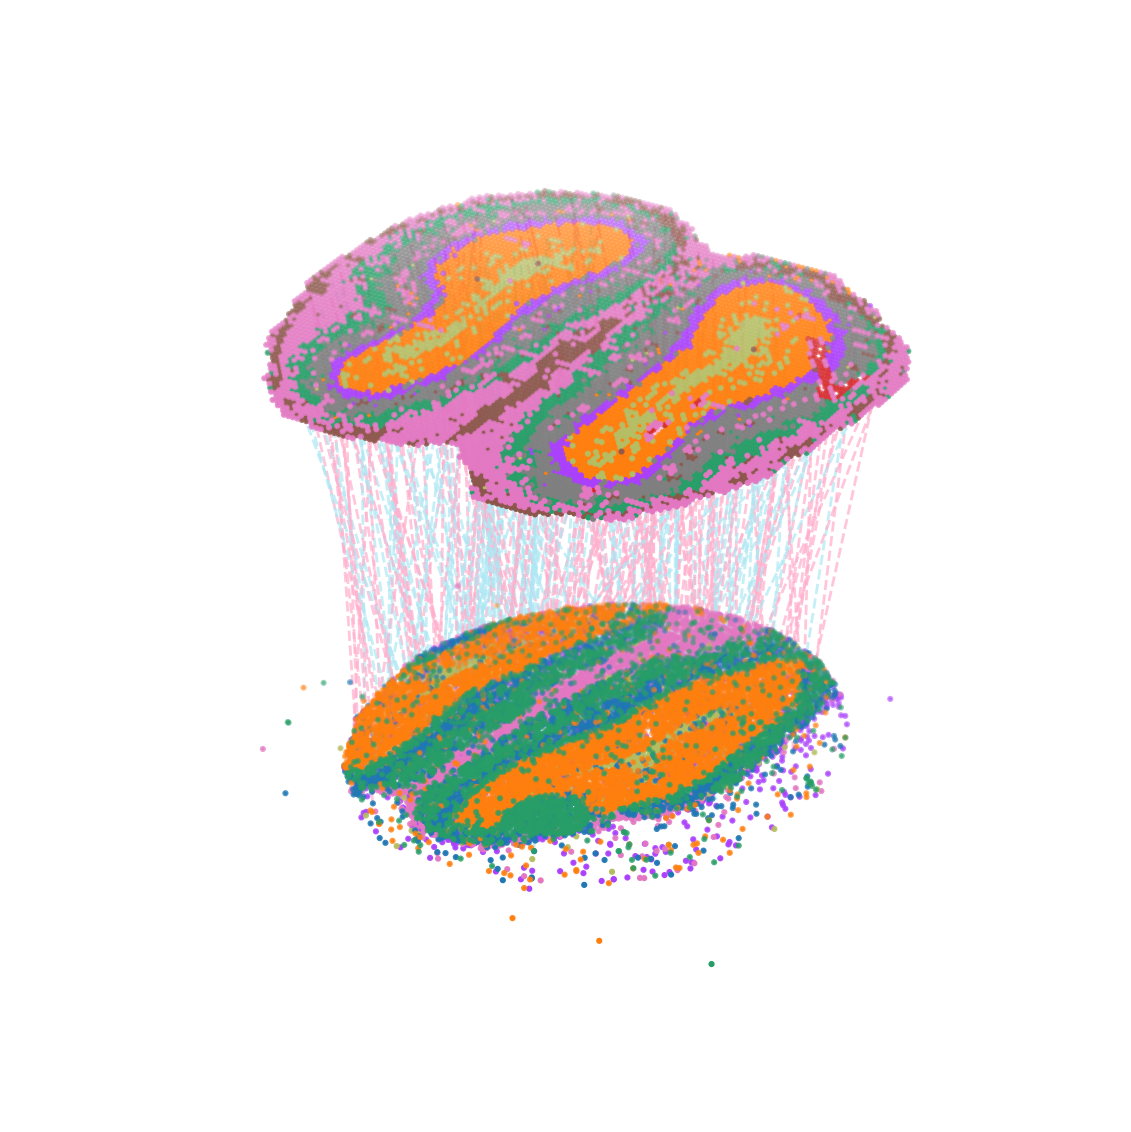

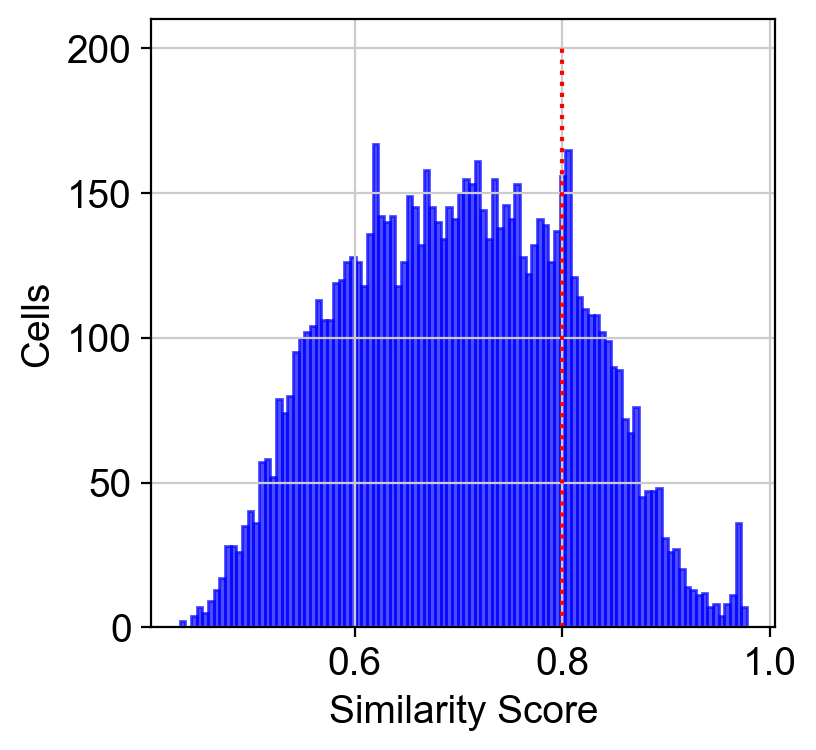

In [10]:
adata1_df = pd.DataFrame({'index': range(embd0.shape[0]),
                        'x': adata_list[0].obsm['spatial'][:,0],
                        'y': adata_list[0].obsm['spatial'][:,1],
                        'celltype': adata_list[0].obs['celltype']
                         })
adata2_df = pd.DataFrame({'index': range(embd1.shape[0]),
                        'x': adata_list[1].obsm['spatial'][:,0],
                        'y': adata_list[1].obsm['spatial'][:,1],
                        'celltype': adata_list[1].obs['celltype']
                         })

matching = np.array([range(index.shape[0]), best])
best_match = distance[:,0]

multi_align = match_3D_multi(adata1_df, adata2_df, matching, meta='celltype',
                            scale_coordinate=True, subsample_size=300)
multi_align.draw_3D(size=[7, 8], line_width=1, point_size=[1.5,1.5], hide_axis=True)

%matplotlib inline
hist(best_match, cut=0.8)

In [11]:
np.savetxt( output_dir + 'SLAT_embedding_' + experiment_name + '_' + datasets[0] + '.csv', embd0.cpu().detach().numpy(), delimiter="," )
np.savetxt( output_dir + 'SLAT_embedding_' + experiment_name + '_' + datasets[1] + '.csv', embd1.cpu().detach().numpy(), delimiter="," )
adata1_df.to_csv(output_dir + 'SLAT_' + experiment_name + '_' + datasets[0] + '.csv')
adata2_df.to_csv(output_dir + 'SLAT_' + experiment_name + '_' + datasets[1] + '.csv')